In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark
!pip install xgboost pyspark


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [3]:
import pyspark
sc = pyspark.SparkContext(appName="FraudDetection")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 09:03:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("FraudDetection") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()
spark

In [24]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import avg, stddev, count, hour, col, max
from pyspark.ml import Pipeline
from sklearn.manifold import TSNE
import seaborn as sns
from pyspark.sql.functions import desc  # This line is essential for sorting
import json
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth
import networkx as nx
from pyspark.sql.functions import hour, dayofweek, month, to_timestamp
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore")
data_path='/kaggle/input/transactions-data-big-data/Transactions Data/Transactions Data'

# Read the data

In [6]:
from pyspark.sql import functions as F

# Load the users data
users_df = spark.read.csv(f"{data_path}/users.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the columns to double type
users_df = users_df.withColumn("per_capita_income", F.regexp_replace("per_capita_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("yearly_income", F.regexp_replace("yearly_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("total_debt", F.regexp_replace("total_debt", "[\$,]", "").cast("double"))

print(users_df.count())
# Check the count of rows
users_df.show(3)

1219
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|client_id|current_age|retirement_age|birth_year|birth_month|gender|            address|latitude|longitude|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|     1645|         62|            65|      1957|         11|Female|    58 Federal Lane|   41.47|   -81.85|          29692.0|      60541.0|  160456.0|         716|               3|
|     1591|         58|            66|      1961|          6|Female|   2200 Third Drive|   48.28|  -122.62|          16537.0|      33717.0|   58236.0|         698|               6|
|     1959|         46|            59|      1973|          4|  Male|8750 Lake Boulevard|  

In [7]:
from pyspark.sql import functions as F

# Read the transactions data
transactions_df = spark.read.csv(f"{data_path}/transactions.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'amount' column to double type
transactions_df = transactions_df.withColumn("amount", F.regexp_replace("amount", "[\$,]", "").cast("double"))

# Check the count of rows
print(transactions_df.count())
transactions_df.show(3)

8914963
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|     id|               date|client_id|card_id|amount|         use_chip|merchant_id|  merchant_city| mcc|  errors|target|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|7475341|2010-01-01 00:27:00|     1797|   1127| 43.33|Swipe Transaction|      33326|        Kahului|4121|No Error|    No|
|7475347|2010-01-01 00:36:00|      114|   3398| -64.0|Swipe Transaction|      61195|North Hollywood|5541|No Error|    No|
|7475378|2010-01-01 01:19:00|     1575|   2112| 17.14|Swipe Transaction|      29232|         Osprey|4121|No Error|    No|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
only showing top 3 rows



In [8]:
# Read the cards data
cards_df = spark.read.csv(f"{data_path}/cards.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'credit_limit' column to double type
cards_df = cards_df.withColumn("credit_limit", F.regexp_replace("credit_limit", "[\$,]", "").cast("double"))

# Check the count of rows
cards_df.count()

4514

In [9]:
cards_df.printSchema()
users_df.printSchema()
transactions_df.printSchema()

root
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- card_brand: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- card_number: long (nullable = true)
 |-- expires: string (nullable = true)
 |-- cvv: integer (nullable = true)
 |-- has_chip: string (nullable = true)
 |-- num_cards_issued: integer (nullable = true)
 |-- credit_limit: double (nullable = true)
 |-- acct_open_date: string (nullable = true)
 |-- year_pin_last_changed: integer (nullable = true)
 |-- card_on_dark_web: string (nullable = true)

root
 |-- client_id: integer (nullable = true)
 |-- current_age: integer (nullable = true)
 |-- retirement_age: integer (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- birth_month: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- address: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- per_capita_income: double (nullable = true)


In [10]:
trans_cards_df = transactions_df.join(cards_df, on=["client_id", "card_id"], how="left")

final_df = trans_cards_df.join(users_df, on="client_id", how="left")
columns_to_drop = ["id","client_id","card_id","merchant_id","card_on_dark_web_idx","longitude","latitude","date", "card_number", "expires", "cvv", "acct_open_date", "address"]
final_df = final_df.drop(*columns_to_drop)
final_df = final_df.withColumn(
    "merchant_city",
    when(F.lower(F.col("merchant_city")) == "online", "online").otherwise("other")
)
final_df.printSchema()
final_df = final_df.na.fill("Unknown")  # for categorical
final_df = final_df.na.fill(0) 
label_indexer = StringIndexer(inputCol="target", outputCol="label")
final_df = label_indexer.fit(final_df).transform(final_df)
##Convert Categorical Columns
categorical_cols = [col for col, dtype in final_df.dtypes if dtype == 'string' and col != 'target']
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx").fit(final_df) for col in categorical_cols]

for indexer in indexers:
    final_df = indexer.transform(final_df)

# Drop original string columns (except 'target' which is your label)
final_df = final_df.drop(*categorical_cols)


root
 |-- amount: double (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_city: string (nullable = false)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)
 |-- target: string (nullable = true)
 |-- card_brand: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- has_chip: string (nullable = true)
 |-- num_cards_issued: integer (nullable = true)
 |-- credit_limit: double (nullable = true)
 |-- year_pin_last_changed: integer (nullable = true)
 |-- card_on_dark_web: string (nullable = true)
 |-- current_age: integer (nullable = true)
 |-- retirement_age: integer (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- birth_month: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- per_capita_income: double (nullable = true)
 |-- yearly_income: double (nullable = true)
 |-- total_debt: double (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- num_credit_cards: integer (nullable = t

In [11]:
final_df.printSchema()

root
 |-- amount: double (nullable = false)
 |-- mcc: integer (nullable = true)
 |-- target: string (nullable = false)
 |-- num_cards_issued: integer (nullable = true)
 |-- credit_limit: double (nullable = false)
 |-- year_pin_last_changed: integer (nullable = true)
 |-- current_age: integer (nullable = true)
 |-- retirement_age: integer (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- birth_month: integer (nullable = true)
 |-- per_capita_income: double (nullable = false)
 |-- yearly_income: double (nullable = false)
 |-- total_debt: double (nullable = false)
 |-- credit_score: integer (nullable = true)
 |-- num_credit_cards: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- use_chip_idx: double (nullable = false)
 |-- merchant_city_idx: double (nullable = false)
 |-- errors_idx: double (nullable = false)
 |-- card_brand_idx: double (nullable = false)
 |-- card_type_idx: double (nullable = false)
 |-- has_chip_idx: double (nullable = false)
 |-- car

In [12]:

feature_cols = [col for col in final_df.columns if col not in ["target", "label" ]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
final_df = assembler.transform(final_df)
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)


# logisitc regression

In [14]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)


25/04/18 09:17:13 WARN MemoryStore: Not enough space to cache rdd_321_6 in memory! (computed 33.0 MiB so far)
25/04/18 09:17:13 WARN BlockManager: Persisting block rdd_321_6 to disk instead.
25/04/18 09:17:14 WARN MemoryStore: Not enough space to cache rdd_321_5 in memory! (computed 65.0 MiB so far)
25/04/18 09:17:14 WARN BlockManager: Persisting block rdd_321_5 to disk instead.
25/04/18 09:17:14 WARN MemoryStore: Not enough space to cache rdd_321_4 in memory! (computed 65.0 MiB so far)
25/04/18 09:17:14 WARN BlockManager: Persisting block rdd_321_4 to disk instead.
25/04/18 09:17:14 WARN MemoryStore: Not enough space to cache rdd_321_7 in memory! (computed 65.0 MiB so far)
25/04/18 09:17:14 WARN BlockManager: Persisting block rdd_321_7 to disk instead.
25/04/18 09:17:16 WARN MemoryStore: Not enough space to cache rdd_321_5 in memory! (computed 65.0 MiB so far)
25/04/18 09:17:17 WARN MemoryStore: Not enough space to cache rdd_321_7 in memory! (computed 65.0 MiB so far)
25/04/18 09:17:3

# random forest

In [13]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)


25/04/18 09:07:11 WARN MemoryStore: Not enough space to cache rdd_240_2 in memory! (computed 104.7 MiB so far)
25/04/18 09:07:11 WARN BlockManager: Persisting block rdd_240_2 to disk instead.
25/04/18 09:07:11 WARN MemoryStore: Not enough space to cache rdd_240_1 in memory! (computed 104.7 MiB so far)
25/04/18 09:07:11 WARN BlockManager: Persisting block rdd_240_1 to disk instead.
25/04/18 09:07:12 WARN MemoryStore: Not enough space to cache rdd_240_0 in memory! (computed 104.7 MiB so far)
25/04/18 09:07:12 WARN BlockManager: Persisting block rdd_240_0 to disk instead.
25/04/18 09:07:12 WARN MemoryStore: Not enough space to cache rdd_240_3 in memory! (computed 104.7 MiB so far)
25/04/18 09:07:12 WARN BlockManager: Persisting block rdd_240_3 to disk instead.
25/04/18 09:07:22 WARN MemoryStore: Not enough space to cache rdd_240_2 in memory! (computed 104.7 MiB so far)
25/04/18 09:07:22 WARN MemoryStore: Not enough space to cache rdd_240_1 in memory! (computed 104.7 MiB so far)
25/04/18 0

# XGBoost

In [16]:
from xgboost.spark import SparkXGBClassifier

xgb = SparkXGBClassifier(
    features_col="features",
    label_col="label",
    prediction_col="prediction",
    max_depth=5,
    eta=0.1,
    num_round=50,
    num_workers=2  # Set according to your cluster
)

xgb_model = xgb.fit(train_data)
xgb_predictions = xgb_model.transform(test_data)


25/04/18 09:19:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[09:21:05] task 1 got new rank 0                                                        (0 + 2) / 2]
[09:21:06] task 0 got new rank 1
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [09:21:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [09:21:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)


# SVM

In [17]:
from pyspark.ml.classification import LinearSVC

# Train SVM model
svm = LinearSVC(labelCol="label", featuresCol="features", maxIter=10, regParam=0.1)
svm_model = svm.fit(train_data)
svm_predictions = svm_model.transform(test_data)


25/04/18 09:23:34 WARN MemoryStore: Not enough space to cache rdd_490_5 in memory! (computed 65.0 MiB so far)
25/04/18 09:23:34 WARN BlockManager: Persisting block rdd_490_5 to disk instead.
25/04/18 09:23:34 WARN MemoryStore: Not enough space to cache rdd_490_7 in memory! (computed 33.0 MiB so far)
25/04/18 09:23:34 WARN BlockManager: Persisting block rdd_490_7 to disk instead.
25/04/18 09:23:34 WARN MemoryStore: Not enough space to cache rdd_490_6 in memory! (computed 65.0 MiB so far)
25/04/18 09:23:34 WARN BlockManager: Persisting block rdd_490_6 to disk instead.
25/04/18 09:23:37 WARN MemoryStore: Not enough space to cache rdd_490_6 in memory! (computed 33.0 MiB so far)
25/04/18 09:23:54 WARN MemoryStore: Not enough space to cache rdd_490_11 in memory! (computed 33.0 MiB so far)
25/04/18 09:23:54 WARN BlockManager: Persisting block rdd_490_11 to disk instead.
25/04/18 09:23:55 WARN MemoryStore: Not enough space to cache rdd_490_9 in memory! (computed 65.0 MiB so far)
25/04/18 09:23

In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Binary AUC evaluator (for ROC curve)
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Multiclass evaluator for precision, recall, F1
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

def evaluate_model(predictions, model_name="Model"):
    print(f"=== {model_name} ===")
    print("AUC:", binary_evaluator.evaluate(predictions))
    print("Weighted Precision:", multiclass_evaluator.setMetricName("weightedPrecision").evaluate(predictions))
    print("Weighted Recall:", multiclass_evaluator.setMetricName("weightedRecall").evaluate(predictions))
    print("F1 Score:", multiclass_evaluator.setMetricName("f1").evaluate(predictions))

    print()

# Run evaluation
evaluate_model(lr_predictions, "Logistic Regression")
evaluate_model(rf_predictions, "Random Forest")
evaluate_model(xgb_predictions, "XGBoost")
evaluate_model(svm_predictions, "SVM")


=== Logistic Regression ===


AUC: 0.8489003699552382


Weighted Precision: 0.9975433187431181


Weighted Recall: 0.9985480186176778


F1 Score: 0.9978376027361923


F1 Score: 0.9978376027361923

=== Random Forest ===


AUC: 0.8552163965897529


Weighted Precision: 0.9987168606253122


Weighted Recall: 0.998715209673293


F1 Score: 0.9982019757059538


F1 Score: 0.9982019757059538

=== XGBoost ===


AUC: 0.9545223869483647


Weighted Precision: 0.9990545518244829


Weighted Recall: 0.999066423098847


F1 Score: 0.9988491749186588


F1 Score: 0.9988491749186588

=== SVM ===


AUC: 0.8371952036004195


Weighted Precision: 0.997110470565461


Weighted Recall: 0.9985541900995965


F1 Score: 0.9978318081190191


F1 Score: 0.9978318081190191



In [27]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictions_and_labels = xgb_predictions.select("prediction", "label").rdd

metrics = MulticlassMetrics(predictions_and_labels)

confusion_matrix = metrics.confusionMatrix()

print("Confusion Matrix for XGBoost:")
print(confusion_matrix)

Confusion Matrix for XGBoost:
DenseMatrix([[1.779802e+06, 1.300000e+01],
             [1.651000e+03, 9.260000e+02]])


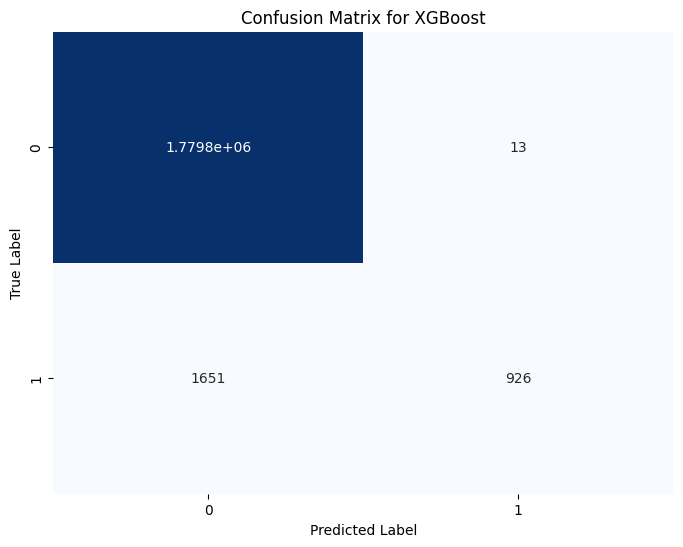

In [28]:

# Extracting the confusion matrix as a NumPy array
confusion_matrix_np = confusion_matrix.toArray()

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_np, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=True, yticklabels=True)

# Adding labels and title
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()
